## 第十週：主題模型（中文）

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為7個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [3]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

In [6]:
udn = pd.read_csv("data/東森新聞.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,慢活安平古城 最美富人灣凌空景觀宅、訂金到交屋自備78萬起｜東森新聞,https://news.ebc.net.tw/news/article/365123,2023-05-05 14:00:00,財經,台南安平區除有歷史悠久的古蹟外，開發近20年的「五期重劃區」兼具生活機能及「慢活」悠閒步調，...,EBC
1,2,巴菲特讚台積電了不起 但投資日本比台灣自在｜東森新聞,https://news.ebc.net.tw/news/article/365550,2023-05-08 11:30:00,財經,美國「股神」巴菲特（WarrenBuffet）今天盛讚台積電是「了不起的公司」，但承認旗下波...,EBC
2,3,期交所+金融機構送愛 捐贈金額7500萬創高｜東森新聞,https://news.ebc.net.tw/news/article/365827,2023-05-10 17:31:00,財經,"為了幫助弱勢族群，期交所攜手金融機構辦理食物銀行，捐贈食物和生活用品，今年總捐贈金額更達7,...",EBC


In [7]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,台南安平區除有歷史悠久的古蹟外開發近年的五期重劃區兼具生活機能及慢活悠閒步調是許多在地人心之...,https://news.ebc.net.tw/news/article/365123,財經,2023-05-05 14:00:00
1,美國股神巴菲特今天盛讚台積電是了不起的公司但承認旗下波克夏海瑟威公司把資金配置在日本比配置在...,https://news.ebc.net.tw/news/article/365550,財經,2023-05-08 11:30:00
2,為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食物和生活用品今年總捐贈金額更達萬元是歷年...,https://news.ebc.net.tw/news/article/365827,財經,2023-05-10 17:31:00


In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\user\sma_studygroup\dict\dict.txt.big ...
2024-05-01 19:47:13,106 : DEBUG : Building prefix dict from c:\Users\user\sma_studygroup\dict\dict.txt.big ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u258d866eabe392cb684a415aa4745b5c.cache
2024-05-01 19:47:13,109 : DEBUG : Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u258d866eabe392cb684a415aa4745b5c.cache
Loading model cost 1.274 seconds.
2024-05-01 19:47:14,382 : DEBUG : Loading model cost 1.274 seconds.
Prefix dict has been built successfully.
2024-05-01 19:47:14,384 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,台南安平區除有歷史悠久的古蹟外開發近年的五期重劃區兼具生活機能及慢活悠閒步調是許多在地人心之...,https://news.ebc.net.tw/news/article/365123,財經,2023-05-05 14:00:00,"[台南, 安平, 區除, 歷史悠久, 古蹟, 開發, 近年, 五期, 重劃, 兼具, 生活,..."
1,美國股神巴菲特今天盛讚台積電是了不起的公司但承認旗下波克夏海瑟威公司把資金配置在日本比配置在...,https://news.ebc.net.tw/news/article/365550,財經,2023-05-08 11:30:00,"[美國, 股神, 巴菲特, 今天, 盛讚, 台積, 電是, 了不起, 公司, 承認, 旗下,..."
2,為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食物和生活用品今年總捐贈金額更達萬元是歷年...,https://news.ebc.net.tw/news/article/365827,財經,2023-05-10 17:31:00,"[幫助, 弱勢, 族群, 期交所, 攜手, 金融機構, 辦理, 食物, 銀行, 捐贈, 食物..."
3,今天舉辦年度開發者大會發表款硬體新產品包括中階手機折疊手機及平板電腦並宣布旗下生成式人工智慧...,https://news.ebc.net.tw/news/article/365885,財經,2023-05-11 10:01:00,"[今天, 舉辦, 年度, 開發者, 大會, 發表, 硬體, 產品, 包括, 中階, 手機, ..."
4,日前一輛新車因停車格塌陷而爆出新竹天坑事件以及快速道路死亡車禍引起汽車險業者高度關注雖然兩起...,https://news.ebc.net.tw/news/article/366027,財經,2023-05-12 09:21:00,"[日前, 一輛, 新車, 停車, 塌陷, 爆出, 新竹, 天坑, 事件, 快速道路, 死亡,..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [9]:
udn['artCatagory'].unique()

array(['財經', '健康', '政治', '體育'], dtype=object)

In [10]:
## 定義主題(設定index)
finance_cnt = udn.loc[udn['artCatagory'] == '財經',:]['words'].explode().value_counts().head(100)
finance_cnt.index

Index(['公司', '台灣', '表示', '員工', '今年', '市場', '投資', '美國', '台積電', '萬元', '超過', '已經',
       '現在', '日本', '指出', '目前', '今天', '億元', '民眾', '持續', '去年', '指數', '股價', '晶片',
       '影響', '日圓', '經濟', '台積', '科技', '裁員', '報導', '未來', '美元', '利率', '中國', '全球',
       '台股', '認為', '集團', '積電', '平均', '上漲', '董事長', '成長', '台幣', '產業', '投資人',
       '仁勳', '增加', '半導體', '輝達', '金額', '股票', '最高', '漲幅', '價格', '問題', '需求', '進行',
       '薪資', '宣布', '調整', '時間', '網友', '企業', '預期', '蘋果', '銀行', '來到', '工作', '過去',
       '使用', '預計', '熊本', '一度', '房屋', '執行長', '相關', '主要', '億美元', '表現', '政府',
       '今日', '比較', '包括', '真的', '出現', '基金', '覺得', '升息', '技術', '發展', '機會', '以上',
       '需要', '最新', '成本', '大陸', '部分', '最大'],
      dtype='object', name='words')

In [11]:
health_cnt = udn.loc[udn['artCatagory'] == '健康',:]['words'].explode().value_counts().head(200)
pprint(" ".join(health_cnt.index))

('醫師 症狀 發現 表示 治療 出現 導致 患者 造成 健康 感染 指出 建議 問題 容易 檢查 疾病 身體 提醒 醫院 增加 研究 風險 影響 嚴重 '
 '食物 民眾 使用 發生 就醫 避免 藥物 病毒 台灣 需要 原因 許多 時間 一名 女性 癌症 已經 運動 男性 產生 進行 以上 手術 無法 引起 '
 '發炎 飲食 超過 睡眠 罹患 分享 常見 流感 包括 情況 細菌 攝取 減少 醫生 狀況 比較 長期 血管 透過 病患 持續 注意 目前 通常 疫苗 '
 '改善 心臟 疼痛 皮膚 壓力 生活 糖尿病 降低 對此 是否 功能 病人 像是 授權 正常 脂肪 方式 疫情 慢性 預防 主要 死亡 最後 一定 男子 '
 '一種 認為 習慣 孩子 特別 重要 肺炎 補充 一些 提到 腫瘤 診斷 引發 說明 相關 咳嗽 族群 選擇 食品 明顯 每天 小時 肌肉 營養師 應該 '
 '個案 異常 覺得 工作 來源 接受 尤其 報導 控制 呼吸道 效果 幫助 真的 腎臟 腸胃 接種 轉載 肝臟 危險 診所 感到 醫療 血液 顯示 女子 '
 '解釋 突然 感冒 機率 熱量 相當 發燒 代謝 知道 含有 分鐘 刺激 環境 食用 透露 接觸 人體 網友 急診 臉書 心血管 之後 案例 大量 維持 '
 '呼籲 感覺 現在 有效 水果 專家 一直 乳癌 確診 急性 最近 疾管署 黴漿 新冠 過去 情緒 服用 細胞 發文 神經 眼睛 血糖 重症 下降 文章')


In [12]:
politics_cnt = udn.loc[udn['artCatagory'] == '政治',:]['words'].explode().value_counts().head(200)
pprint(" ".join(politics_cnt.index))

('總統 國民黨 立委 民進黨 柯文哲 侯友宜 台灣 民眾黨 參選人 市長 表示 賴清德 候選人 支持 主席 現在 選舉 民調 希望 郭台銘 韓國 已經 '
 '議員 問題 萬安 今天 政治 大選 強調 認為 台北 政府 趙少康 應該 一定 最後 藍營 政黨 媒體 侯友 院長 未來 國家 真的 當選 民眾 中國 '
 '台北市 指出 知道 新北 合作 時間 選情 中華民國 藍白合 進行 參選 立法院 地方 選戰 報導 覺得 朱立倫 發言人 過去 面對 能夠 兩岸 對此 '
 '爭議 回應 支持者 相關 綠營 一起 分區 針對 是否 事情 重要 質疑 藍白 政策 投票 提出 目前 美國 徐巧 持續 競選 接受 今日 外界 看到 '
 '這是 宣布 議題 決定 英文 討論 社會 藍綠 所有 代表 清楚 調查 國會 一下 人選 擔任 團結 執政 活動 市府 現場 副手 清德 選民 民主 '
 '記者 臉書 選票 蕭美琴 這次 需要 和平 當時 記者會 出席 繼續 即時 雙方 黨內 努力 提到 總統大選 選區 要求 安全 比較 方式 包括 傳出 '
 '似乎 馬英九 公布 處理 之後 公開 事件 陣營 部分 成為 黃國 吳欣盈 造勢 高雄 影響 說明 發生 關係 力量 中央 整合 關注 過程 提名 道歉 '
 '發文 完全 盧秀燕 不斷 一次 透過 機會 團隊 共識 相信 協商 行程 共同 有人 立法 無法 高虹安 倒數 下午 主委 工作 了解 引發 年輕人 '
 '一直 特別 大陸 直接 最大 創辦人 國際')


In [13]:
exercise_cnt = udn.loc[udn['artCatagory'] == '體育',:]['words'].explode().value_counts().head(200)
pprint(" ".join(exercise_cnt.index))

('亞運 選手 台灣 中華隊 比賽 大谷 金牌 拿下 大運 今天 球員 表示 日本 最後 杭州 聯盟 球迷 賽事 中國 奧運 球隊 今年 教練 朋友 表現 '
 '決賽 翔平 成績 中華 投手 已經 希望 對手 這次 追蹤 最終 快來 當個 項目 美國 球團 銅牌 參加 男子 覺得 擊敗 道奇 棒球 公尺 今日 '
 '進行 女子 目前 晉級 世界 國手 成都 巨蛋 好手 羽球 機會 公斤 南韓 冠軍 職棒 現在 獲得 成功 銀牌 生涯 真的 球星 一起 順利 以比 '
 '網友 時間 領先 運動 雙方 報導 韓國 之後 結束 台北 媒體 相當 兄弟 國際 獎牌 訓練 總教練 李智凱 門票 期待 全壘打 兩人 面對 代表隊 '
 '水原 正式 過去 透露 隊友 體育 大陸 成為 宣布 啦啦隊 桌球 本屆 樂天 取得 賽後 繼續 登場 合約 第一 跆拳道 當時 楊勇緯 敲出 得分 '
 '去年 一場 再度 組合 加油 紀錄 中信 先發 擔任 看到 中國隊 目標 一次 調整 開心 比較 一直 籃球 日本隊 參賽 接受 失誤 出賽 知道 可惜 '
 '強賽 體操 東森 東京 無法 王冠 奪下 巴黎 柔道 主播 指出 準備 持續 挑戰 這是 三振 一度 隨後 能夠 雲豹 確定 直接 狀況 亞洲 許多 '
 '展現 這場 壓力 動作 公開賽 林書豪 職籃 實力 出現 遭到 認為 賽季 台灣隊 球場 第局 影響 預賽 粉絲 開幕 進入 張誌家 中職 對方 舉行 '
 '排名第 拿到 連續')


In [14]:
custom_topic_word = {
    "財金": [
        "投資",
        "億元",
        "市場",
        "萬元",
        "股價",
        "指數",
        "美元",
        "日圓",
        "台幣",
        "股票",
        "金額",
        "升息",
        "利率",
        "基金",
        "投資人",
        "全球",
        "漲幅",
        "成本",
        "產業"
    ],
    "健康": [
        "醫師",
        "症狀",
        "發現",
        "糖尿病",
        "治療",
        "患者",
        "健康",
        "感染",
        "建議",
        "慢性",
        "檢查",
        "疾病",
        "身體",
        "醫院",
        "疫苗",
        "研究",
        "風險",
        "影響",
        "嚴重",
        "食物",
        "呼吸道",
        "就醫",
        "避免",
        "藥物",
        "病毒",
        "感冒",
        "診斷",
        "時間",
        "急診",
        "癌症",
        "異常",
        "心血管",
        "手術",
        "發炎",
        "飲食",
        "腫瘤",
        "睡眠",
        "罹患",
        "代謝"
    ],
    "政治": [
        "總統",
        "國民黨",
        "立委",
        "民進黨",
        "柯文哲",
        "侯友宜",
        "台灣",
        "民眾黨",
        "參選人",
        "市長",
        "賴清德",
        "候選人",
        "支持",
        "主席",
        "選舉",
        "民調",
        "郭台銘",
        "議員",
        "萬安",
        "政治",
        "大選",
        "台北",
        "政府",
        "趙少康",
        "藍營",
        "政黨",
        "院長",
        "國家",
        "當選",
        "台北市",
        "新北",
        "選情",
        "中華民國",
        "藍白合",
        "參選",
        "立法院"
    ],
    "體育":[
        '亞運',
        '選手',
        '台灣',
        '中華隊',
        '比賽',
        '金牌',
        '決賽',
        '成績',
        '對手',
        '美國',
        '銅牌',
        '男子',
        '女子',
        '晉級',
        '世界',
        '冠軍',
        '獲得',
        '成功',
        '運動',
        '韓國',
        '奧運',
        '國際',
        '訓練',
        '獎牌',
        '體育',
        '棒球',
        '羽球',
        '跆拳道',
        '柔道',
        '籃球',
        '杭州',
        '巨蛋',
        '職棒',
        '體操',
        '網友',
        '聯盟',
        '球迷',
        '球隊',
        '教練',
        '球員'
    ]
}

In [15]:
# 把全部定義過的主題詞彙彙整在一起
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [16]:
vocabularies

array(['世界', '中華民國', '中華隊', '主席', '亞運', '代謝', '侯友宜', '候選人', '健康', '億元',
       '全球', '冠軍', '利率', '升息', '參選', '參選人', '台北', '台北市', '台幣', '台灣',
       '呼吸道', '嚴重', '國家', '國民黨', '國際', '基金', '大選', '奧運', '女子', '對手', '就醫',
       '巨蛋', '市場', '市長', '建議', '影響', '心血管', '急診', '患者', '感冒', '感染', '慢性',
       '成功', '成本', '成績', '手術', '投資', '投資人', '指數', '支持', '政府', '政治', '政黨',
       '教練', '新北', '日圓', '時間', '晉級', '杭州', '柔道', '柯文哲', '棒球', '檢查', '比賽',
       '民眾黨', '民調', '民進黨', '決賽', '治療', '漲幅', '獎牌', '獲得', '球員', '球迷', '球隊',
       '產業', '男子', '異常', '當選', '疫苗', '疾病', '病毒', '症狀', '癌症', '發炎', '發現',
       '睡眠', '研究', '立委', '立法院', '籃球', '糖尿病', '網友', '總統', '罹患', '美元', '美國',
       '羽球', '聯盟', '職棒', '股價', '股票', '腫瘤', '萬元', '萬安', '藍營', '藍白合', '藥物',
       '訓練', '診斷', '議員', '賴清德', '趙少康', '跆拳道', '身體', '運動', '選情', '選手',
       '選舉', '避免', '郭台銘', '醫師', '醫院', '金牌', '金額', '銅牌', '院長', '韓國', '風險',
       '食物', '飲食', '體操', '體育'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [17]:
udn_corpus = udn['words'].map(" ".join)
udn_corpus

0       台南 安平 區除 歷史悠久 古蹟 開發 近年 五期 重劃 兼具 生活 機能 慢活 悠閒 步調...
1       美國 股神 巴菲特 今天 盛讚 台積 電是 了不起 公司 承認 旗下 波克夏海瑟威 公司 資...
2       幫助 弱勢 族群 期交所 攜手 金融機構 辦理 食物 銀行 捐贈 食物 生活用品 今年 捐贈...
3       今天 舉辦 年度 開發者 大會 發表 硬體 產品 包括 中階 手機 折疊 手機 平板 電腦 ...
4       日前 一輛 新車 停車 塌陷 爆出 新竹 天坑 事件 快速道路 死亡 車禍 引起 汽車 業者...
                              ...                        
8204    美國 職棒 今天 號有 許多 精采 守備 球員 每個 出神入化 表演 許多 精彩 接殺 今日...
8205    美國 職棒 聯盟 洛杉磯 道奇 球星 大谷 翔平 對戰 華盛頓 國民 擊出 初速 英里 英尺...
8206    全中運 游泳 項目 落幕 沒想到 風波 尚未 停歇 雲林 高中 選手 日前 熱身 跳水 違反...
8207    日籍 球星 大谷 翔平 最近 真的 昨天 之前 連續 兩天 開轟 今天 則是 掃出 二壘 道...
8208    今日 下午 球星 法國 跑車 東尼帕克 現身 桃機 機場 聚集 許多 球迷 一同 目睹 偶像...
Name: words, Length: 8209, dtype: object

In [18]:
udn_corpus = udn['words'].map(" ".join)
# 數---定義的詞彙---在各篇文章中出現的次數
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [19]:
# 文章數 X vocabularies字數
udn_matrix.shape

(8209, 133)

In [20]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_財金,topic_健康,topic_政治,topic_體育
0,1,2,0,2
1,4,0,2,3
2,7,2,1,1
3,9,0,4,5
4,7,1,0,0
...,...,...,...,...
8204,0,0,0,10
8205,0,0,0,12
8206,0,0,2,18
8207,0,1,0,3


In [21]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_財金,topic_健康,topic_政治,topic_體育
0,0.200000,0.400000,0.000000,0.400000
1,0.444444,0.000000,0.222222,0.333333
2,0.636364,0.181818,0.090909,0.090909
3,0.500000,0.000000,0.222222,0.277778
4,0.875000,0.125000,0.000000,0.000000


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

**4.1 正式處理新聞**

In [22]:
docs = udn['words'].to_list()
docs[0]

['台南',
 '安平',
 '區除',
 '歷史悠久',
 '古蹟',
 '開發',
 '近年',
 '五期',
 '重劃',
 '兼具',
 '生活',
 '機能',
 '慢活',
 '悠閒',
 '步調',
 '許多',
 '人心',
 '質感',
 '生活圈',
 '近期',
 '千億',
 '開發',
 '計畫',
 '聚焦',
 '安平',
 '灣區',
 '繼亞果',
 '遊艇',
 '集團',
 '投資',
 '開發',
 '國際',
 '城後台灣',
 '港務',
 '公司',
 '南仁湖',
 '公司',
 '簽約',
 '規畫',
 '打造',
 '規模',
 '最大',
 '濱海',
 '綜合',
 '度假',
 '城要將',
 '安平',
 '古城',
 '升至',
 '國際',
 '城市',
 '高度',
 '想像',
 '一下',
 '澳洲',
 '黃金海岸',
 '濱海',
 '生活',
 '擁有',
 '蔚藍海岸',
 '溫暖',
 '陽光',
 '多元',
 '美食',
 '休閒',
 '體驗',
 '安平港',
 '灣區',
 '未來',
 '樣貌',
 '尤其',
 '市政',
 '特區',
 '周圍',
 '生活',
 '機能',
 '相當',
 '豐富',
 '慈濟',
 '中小學',
 '明星',
 '學區',
 '文教',
 '氣息',
 '濃厚',
 '座落在',
 '城中',
 '核心',
 '推案',
 '潤隆',
 '鉑悦',
 '擁有',
 '基地',
 '打造',
 '高層',
 '精品',
 '景觀',
 '住宅',
 '南面',
 '北都',
 '無敵',
 '大景將',
 '安平',
 '古城',
 '之美',
 '盡收眼底',
 '基地',
 '健康',
 '三路',
 '潤隆',
 '鉑悦',
 '面南',
 '一整片',
 '紅樹林',
 '保護區',
 '視野',
 '向外',
 '延伸',
 '蔚藍',
 '河口',
 '每個',
 '房間',
 '大面',
 '開窗',
 '俯瞰',
 '波光粼粼',
 '絕美',
 '海景',
 '面北',
 '則是',
 '市政',
 '特區',
 '新光',
 '三越',
 '商圈',
 '連鎖',
 '賣場',
 '特色',
 '餐廳',
 '林立

In [23]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-01 19:49:56,347 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2024-05-01 19:49:58,350 : INFO : built Dictionary<100696 unique tokens: ['一下', '一整片', '三房', '三越', '三路']...> from 8209 documents (total 1452035 corpus positions)
2024-05-01 19:49:58,353 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<100696 unique tokens: ['一下', '一整片', '三房', '三越', '三路']...> from 8209 documents (total 1452035 corpus positions)", 'datetime': '2024-05-01T19:49:58.353769', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2024-05-01 19:49:58,498 : INFO : discarding 77938 tokens: [('一整片', 2), ('三房', 4), ('三路', 3), ('之美', 4), ('五期', 1), ('交屋', 3), ('全齡化', 1), ('兩房', 3), ('再也不是', 2), ('北都', 2)]...
2024-05-01 19:49:58,499 : INFO : keeping 22758 tokens which were in no less than 5 and no more than 8126 (=99.0%) documents
2024-05-01 19:49:58,558 : INFO : resulting dictionary: Dictionary<22758 unique tokens: ['一下', '三越', '中小學', '人心', '休閒']...>


Dictionary<22758 unique tokens: ['一下', '三越', '中小學', '人心', '休閒']...>


In [24]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一下: 0
三越: 1
中小學: 2
人心: 3
休閒: 4
住宅: 5
住戶: 6
保護區: 7
俯瞰: 8
健康: 9
健身房: 10
全案: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [25]:
pprint(" ".join(udn['words'].iloc[600]))


('隨機 街訪民眾 已經 心動 上車 股息 引爆 申購 熱潮 現在 就連 券商 負荷 元大 證券 官網 凌晨 公告 號起 開戶 無法 保證 申購 告訴 來晚 '
 '不見得 得到 最新 像是 台新證 跟進 玉山 證券 公告 截止 就要 停售 這波 申購 實在 瘋狂 好多 銀行 去解 定存 戶頭 錢領 金融業 拆款 '
 '利率 號都 一度 飆上 扣除 季節性 因素 創了 年來 新高 觀察 熱潮 背後 達人 分析 集合 大型 績優股 長期 配息 表現 優於 保單 存款 吸引 '
 '原本 投資 股票 銀行 行員 鄭先生 股市 熱絡 程度 時間 點去 發行 產品 自然 資金 過去 放在 帳上 動用 定存 利率 部位 全部 投入 最近 '
 '真的 過去 多個 客戶 全民 高息 熱潮 聞所未聞 月底 台股 規模 來到 兆元 達人 認為 相較 以前 熱賣 垃圾 債券 基金 目標 到期 保單 投資 '
 '保單 處在 健康 狀態')


In [26]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(9, 1),
 (56, 2),
 (70, 1),
 (111, 1),
 (167, 1),
 (181, 1),
 (214, 1),
 (238, 1),
 (267, 2),
 (268, 1)]

In [27]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [28]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [29]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=15, # 生成幾個主題數
    random_state=2024, # 亂數
)

2024-05-01 19:50:12,689 : INFO : using symmetric alpha at 0.06666666666666667
2024-05-01 19:50:12,691 : INFO : using symmetric eta at 0.06666666666666667
2024-05-01 19:50:12,695 : INFO : using serial LDA version on this node
2024-05-01 19:50:12,730 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 19:50:12,731 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-01 19:50:12,732 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-01 19:50:14,410 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-01 19:50:14,442 : INFO : topic #2 (0.067): 0.006*"醫師" + 0.004*"表示" + 0.003*"超過" + 0.003*"台灣" + 0.003*"指出" + 0.003*"導致" + 0.003*"建議" + 0.003*"問題" + 0.003*"影

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [30]:
ldamodel.print_topics()

2024-05-01 19:50:26,459 : INFO : topic #0 (0.067): 0.013*"柯文哲" + 0.009*"攻城" + 0.009*"球員" + 0.006*"網友" + 0.006*"結婚" + 0.006*"輔選" + 0.005*"民眾黨" + 0.005*"表示" + 0.005*"覺得" + 0.005*"真的"
2024-05-01 19:50:26,461 : INFO : topic #1 (0.067): 0.015*"立委" + 0.014*"國民黨" + 0.013*"柯文哲" + 0.011*"總統" + 0.010*"民眾黨" + 0.007*"候選人" + 0.007*"民進黨" + 0.006*"表示" + 0.006*"台灣" + 0.005*"今天"
2024-05-01 19:50:26,462 : INFO : topic #2 (0.067): 0.114*"水原" + 0.047*"一平" + 0.037*"球團" + 0.034*"奧運" + 0.032*"翻譯" + 0.023*"大谷" + 0.009*"翔平" + 0.007*"國王" + 0.007*"正副" + 0.005*"表示"
2024-05-01 19:50:26,463 : INFO : topic #3 (0.067): 0.015*"球員" + 0.010*"林書豪" + 0.009*"亞運" + 0.008*"表示" + 0.007*"球隊" + 0.007*"新北" + 0.006*"影片" + 0.006*"球場" + 0.006*"媒體" + 0.005*"今天"
2024-05-01 19:50:26,464 : INFO : topic #4 (0.067): 0.040*"雲豹" + 0.013*"杭州" + 0.012*"失分" + 0.012*"分秒" + 0.012*"收下" + 0.011*"改寫" + 0.009*"美聯社" + 0.009*"卡達" + 0.008*"本季" + 0.006*"撤換"
2024-05-01 19:50:26,466 : INFO : topic #5 (0.067): 0.010*"賴佩霞" + 0.008*"女子" + 0.008*"化妝" + 0.007

[(0,
  '0.013*"柯文哲" + 0.009*"攻城" + 0.009*"球員" + 0.006*"網友" + 0.006*"結婚" + 0.006*"輔選" + 0.005*"民眾黨" + 0.005*"表示" + 0.005*"覺得" + 0.005*"真的"'),
 (1,
  '0.015*"立委" + 0.014*"國民黨" + 0.013*"柯文哲" + 0.011*"總統" + 0.010*"民眾黨" + 0.007*"候選人" + 0.007*"民進黨" + 0.006*"表示" + 0.006*"台灣" + 0.005*"今天"'),
 (2,
  '0.114*"水原" + 0.047*"一平" + 0.037*"球團" + 0.034*"奧運" + 0.032*"翻譯" + 0.023*"大谷" + 0.009*"翔平" + 0.007*"國王" + 0.007*"正副" + 0.005*"表示"'),
 (3,
  '0.015*"球員" + 0.010*"林書豪" + 0.009*"亞運" + 0.008*"表示" + 0.007*"球隊" + 0.007*"新北" + 0.006*"影片" + 0.006*"球場" + 0.006*"媒體" + 0.005*"今天"'),
 (4,
  '0.040*"雲豹" + 0.013*"杭州" + 0.012*"失分" + 0.012*"分秒" + 0.012*"收下" + 0.011*"改寫" + 0.009*"美聯社" + 0.009*"卡達" + 0.008*"本季" + 0.006*"撤換"'),
 (5,
  '0.010*"賴佩霞" + 0.008*"女子" + 0.008*"化妝" + 0.007*"美媒" + 0.007*"暈倒" + 0.007*"縫線" + 0.006*"靜脈" + 0.006*"陽明" + 0.006*"愛妻" + 0.005*"不上"'),
 (6,
  '0.013*"調查" + 0.010*"合約" + 0.009*"禁藥" + 0.009*"相關" + 0.008*"表示" + 0.008*"公司" + 0.006*"進行" + 0.005*"政府" + 0.005*"事件" + 0.005*"針對"'),
 (7,
  '0.199*"大谷

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：大巨蛋相關的政治新聞
+ 主題二：總統大選
+ 主題三：大谷翔平翻譯涉賭
+ 主題四：侯友宜體育政見
+ .
+ .
+ 主題十：中職

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [31]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.24236637),
 (2, 0.016229445),
 (4, 0.14978689),
 (5, 0.20179544),
 (8, 0.2657546),
 (9, 0.07175615),
 (13, 0.03290151),
 (14, 0.016731283)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [32]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-01 19:51:17,566 : INFO : -10.000 per-word bound, 1024.2 perplexity estimate based on a held-out corpus of 8209 documents with 1310399 words


-10.00029737114385

In [33]:
np.exp2(-perplexity)

1024.211090651681

In [34]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-01 19:51:22,505 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows


2024-05-01 19:51:37,877 : INFO : 1 batches submitted to accumulate stats from 64 documents (11694 virtual)
2024-05-01 19:51:37,884 : INFO : 2 batches submitted to accumulate stats from 128 documents (23196 virtual)
2024-05-01 19:51:37,890 : INFO : 3 batches submitted to accumulate stats from 192 documents (35100 virtual)
2024-05-01 19:51:37,897 : INFO : 4 batches submitted to accumulate stats from 256 documents (44872 virtual)
2024-05-01 19:51:37,904 : INFO : 5 batches submitted to accumulate stats from 320 documents (54513 virtual)
2024-05-01 19:51:37,921 : INFO : 6 batches submitted to accumulate stats from 384 documents (64936 virtual)
2024-05-01 19:51:37,962 : INFO : 7 batches submitted to accumulate stats from 448 documents (74560 virtual)
2024-05-01 19:51:37,993 : INFO : 8 batches submitted to accumulate stats from 512 documents (85929 virtual)
2024-05-01 19:51:38,008 : INFO : 9 batches submitted to accumulate stats from 576 documents (96652 virtual)
2024-05-01 19:51:38,024 : INF

這個主題的 PMI score:  -0.10131867718604987


In [35]:
NPMI_model_lda.get_coherence_per_topic()

[-0.09707353853512182,
 0.030824963937794426,
 -0.18265651173800632,
 -0.0883656746000475,
 -0.23624250539833178,
 -0.28685657981224266,
 0.0009108888670928628,
 0.012467025431254648,
 0.05579757429977121,
 0.0743743107693578,
 -0.25212151746140155,
 -0.1777209123080197,
 -0.04125179210017831,
 -0.029726470503257454,
 -0.30213941863941185]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [36]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

2024-05-01 19:52:02,059 : INFO : using symmetric alpha at 0.5
2024-05-01 19:52:02,060 : INFO : using symmetric eta at 0.5
2024-05-01 19:52:02,065 : INFO : using serial LDA version on this node
2024-05-01 19:52:02,071 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 19:52:02,072 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-01 19:52:03,690 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-01 19:52:03,696 : INFO : topic #0 (0.500): 0.009*"醫師" + 0.004*"出現" + 0.004*"發現" + 0.004*"表示" + 0.004*"症狀" + 0.003*"導致" + 0.003*"患者" + 0.003*"感染" + 0.003*"指出" + 0.003*"問題"
2024-05-01 19:52:03,699 : INFO : topic #1 (0.500): 0.006*"表示" + 0.005*"台灣" + 0.004*"醫師" + 0.003*"指出" + 0.003*"發現" + 0.003*"問題" + 0.003*"症狀" + 0.003*"公司" + 0.003*"侯友宜" + 0.003*

花費時間: 508.8802044391632 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [40]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5458.459979,0.059759
1,3,4816.093838,0.064092
2,4,4443.688094,0.019778
3,5,4334.293248,0.077850
4,6,4225.706192,0.067238
5,7,4375.836484,0.035225
6,8,4345.231933,0.045746
7,9,4641.054517,0.060419


In [45]:
import matplotlib.pyplot as plt
result.plot.line(x='topic_num', y='perplexity')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\guidedlda\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_3380\1211639233.py", line 2, in <module>
    result.plot.line(x='topic_num', y='perplexity')
  File "c:\Users\user\anaconda3\envs\guidedlda\lib\site-packages\pandas\plotting\_core.py", line 1044, in line
    See Also
  File "c:\Users\user\anaconda3\envs\guidedlda\lib\site-packages\pandas\plotting\_core.py", line 895, in __call__
    plot_backend.__name__, self._parent, args, kwargs
  File "c:\Users\user\anaconda3\envs\guidedlda\lib\site-packages\pandas\plotting\_core.py", line 1862, in _get_plot_backend
  File "c:\Users\user\anaconda3\envs\guidedlda\lib\site-packages\pandas\plotting\_core.py", line 1794, in _load_backend
    The plotting system of pandas uses matplotlib by default, but the idea here
ImportError: matplotlib is r

<Axes: xlabel='topic_num'>

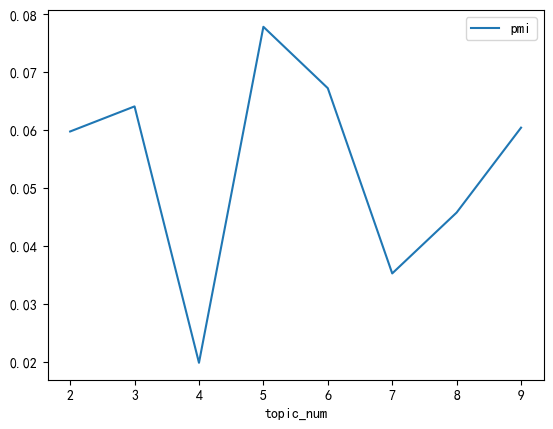

In [50]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 6 之後都不錯，coherence 最高則是 5

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 5 來做 LDAvis 的結果範例

In [53]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-01 19:27:48,281 : INFO : using symmetric alpha at 0.125
2024-05-01 19:27:48,282 : INFO : using symmetric eta at 0.125
2024-05-01 19:27:48,286 : INFO : using serial LDA version on this node
2024-05-01 19:27:48,301 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 8209 documents, updating model once every 2000 documents, evaluating perplexity every 8209 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-01 19:27:48,302 : INFO : PROGRESS: pass 0, at document #2000/8209
2024-05-01 19:27:49,056 : INFO : merging changes from 2000 documents into a model of 8209 documents
2024-05-01 19:27:49,064 : INFO : topic #1 (0.125): 0.006*"台灣" + 0.005*"表示" + 0.004*"侯友宜" + 0.004*"公司" + 0.004*"國民黨" + 0.003*"指出" + 0.003*"發現" + 0.003*"醫師" + 0.003*"問題" + 0.003*"已經"
2024-05-01 19:27:49,066 : INFO : topic #7 (0.125): 0.006*"醫師" + 0.005*"表示" + 0.004*"台灣" + 0.004*"指出" + 0.003*"症狀" + 0.003*"治療" + 0.003*"增加" + 0.003*"造成" + 0.003*"感染" + 0

In [52]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.108016 -0.167005       1        1  53.197247
0     -0.219837  0.177431       2        1  18.453589
2     -0.029823 -0.106101       3        1  14.265323
3      0.199364  0.064697       4        1   8.890419
4      0.158312  0.030978       5        1   5.193423, topic_info=     Term          Freq         Total Category  logprob  loglift
7954   大谷   2324.000000   2324.000000  Default  30.0000  30.0000
1844   總統  10527.000000  10527.000000  Default  29.0000  29.0000
1561  國民黨   9071.000000   9071.000000  Default  28.0000  28.0000
1484   立委   8363.000000   8363.000000  Default  27.0000  27.0000
151    台灣   7491.000000   7491.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
3298   網友    236.092637    977.754086   Topic5  -5.6638   1.5367
321    媒體    272.043386   1838.956086   Topic5  -5.5221   1.0468
324    宣布    236.040031   1251.497747   Topic5  -5.6641   1.2897
145    今天    278.112315   3334.227112   Topic5  -5.5000   0.4738
154    報導    201.149849   1766.938679   Topic5  -5.8240   0.7848

[357 rows x 6 columns], token_table=       Topic      Freq Term
term                       
15871      5  0.997170   一平
21895      2  0.014133  三分球
21895      4  0.989307  三分球
20988      5  0.992651   三振
8181       5  0.991633   下注
...      ...       ...  ...
10176      4  0.002460   飲食
22095      3  0.982461   首局
22095      5  0.009357   首局
22310      3  0.990727   馬龍
20983      4  0.996438   體操

[820 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

可以看到(4,5)很相近，試試看跑5個主題

In [146]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-04-23 12:05:07,254 : INFO : using symmetric alpha at 0.2
2024-04-23 12:05:07,256 : INFO : using symmetric eta at 0.2
2024-04-23 12:05:07,259 : INFO : using serial LDA version on this node
2024-04-23 12:05:07,266 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 6531 documents, updating model once every 2000 documents, evaluating perplexity every 6531 documents, iterating 50x with a convergence threshold of 0.001000
2024-04-23 12:05:07,268 : INFO : PROGRESS: pass 0, at document #2000/6531
2024-04-23 12:05:07,802 : INFO : merging changes from 2000 documents into a model of 6531 documents
2024-04-23 12:05:07,805 : INFO : topic #0 (0.200): 0.008*"表示" + 0.007*"今天" + 0.006*"美國" + 0.005*"以色列" + 0.005*"報導" + 0.005*"烏克蘭" + 0.005*"俄羅斯" + 0.004*"球隊" + 0.003*"戰爭" + 0.003*"去年"
2024-04-23 12:05:07,805 : INFO : topic #1 (0.200): 0.007*"今天" + 0.005*"去年" + 0.005*"球員" + 0.005*"表示" + 0.005*"今年" + 0.005*"美國" + 0.004*"球隊" + 0.004*"聯盟" + 0.003*"台灣" + 0.00

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.107157 -0.147625       1        1  26.782069
2     -0.266617  0.064987       2        1  21.630561
4     -0.131785 -0.103167       3        1  20.842863
1      0.119592  0.237112       4        1  17.191071
3      0.171653 -0.051307       5        1  13.553437, topic_info=     Term         Freq        Total Category  logprob  loglift
4393   億元  4879.000000  4879.000000  Default  30.0000  30.0000
1283   營收  2955.000000  2955.000000  Default  29.0000  29.0000
2648   中國  8849.000000  8849.000000  Default  28.0000  28.0000
1222   市場  4333.000000  4333.000000  Default  27.0000  27.0000
6990   香港  3462.000000  3462.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
206    認為   421.615068  2070.914606   Topic5  -5.8937   0.4069
9149   北京   357.480794  1202.800423   Topic5  -6.0587   0.7852
9494  人民幣   363.576765  1532.709039   Topic5  -6.0418   0.5597
1031   已經   341.878958  1546.067592   Topic5  -6.1033   0.4895
128    期間   302.578768  1213.951639   Topic5  -6.2254   0.6092

[426 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
11328      1  0.996056    一架
2569       4  0.998824   三分球
19379      5  0.985155    三無
15713      1  0.016531  上市公司
15713      2  0.079347  上市公司
...      ...       ...   ...
19815      1  0.994159    高合
19815      3  0.005585    高合
3899       4  0.040291    高校
3899       5  0.956900    高校
15603      2  0.990828    點收

[964 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [51]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [53]:
import guidedlda

In [54]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一中', '一圈', '一壘手', '一定', '一起', '上季', '下滑', '不在', '不斷', '不算')

In [55]:
word2id = dictionary.token2id

In [74]:
seed_topic_list = [
    ["大谷", "春訓", "聯盟", "先發", "道奇"],
    ["股票", "投資", "外資", "利率", "基金"],
    ["台積電", "半導體", "科技", "鴻海", "電動車"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["全球", "美國", "國際", "世界", "日本"]
]

In [75]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [76]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [77]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-04-15 04:08:07,337 : INFO : n_documents: 6531
2024-04-15 04:08:07,338 : INFO : vocab_size: 19932
2024-04-15 04:08:07,340 : INFO : n_words: 1128398
2024-04-15 04:08:07,341 : INFO : n_topics: 6
2024-04-15 04:08:07,343 : INFO : n_iter: 100
2024-04-15 04:08:12,321 : INFO : <0> log likelihood: -12285099
2024-04-15 04:08:13,195 : INFO : <20> log likelihood: -9618869
2024-04-15 04:08:14,032 : INFO : <40> log likelihood: -9540600
2024-04-15 04:08:14,865 : INFO : <60> log likelihood: -9518862
2024-04-15 04:08:15,696 : INFO : <80> log likelihood: -9509815
2024-04-15 04:08:16,525 : INFO : <99> log likelihood: -9504992


In [79]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 今天 球員 比賽 聯盟 球隊 球迷 今年 去年 選手 表示
Topic 1: 市場 指數 投資 台股 投資人 上漲 股價 預期 表現 億元
Topic 2: 億元 營收 今年 成長 去年 市場 公司 需求 產品 持續
Topic 3: 中國 大陸 經濟 發展 香港 報導 台灣 表示 企業 國家
Topic 4: 美國 表示 總統 俄羅斯 報導 烏克蘭 以色列 拜登 今天 國家
Topic 5: 表示 報導 網友 香港 日本 萬元 影片 發現 已經 旅遊


/opt/anaconda3/envs/py38_sma/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.245685 -0.028676       1        1  18.663582
3      0.020675 -0.187939       2        1  17.605388
5      0.129803  0.041963       3        1  16.555546
1     -0.218459  0.059895       4        1  16.487771
0      0.122567  0.254648       5        1  15.943017
4      0.191100 -0.139891       6        1  14.744696, topic_info=     Term         Freq        Total Category  logprob  loglift
2648   中國  7105.000000  7105.000000  Default  30.0000  30.0000
1283   營收  2577.000000  2577.000000  Default  29.0000  29.0000
6267   大陸  3877.000000  3877.000000  Default  28.0000  28.0000
1307   美國  4792.000000  4792.000000  Default  27.0000  27.0000
4393   億元  3954.000000  3954.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
40     去年   516.431215  4561.250414   Topic6  -5.7751  -0.2641
321    包括   431.526371  2017.925066   Topic6  -5.9547   0.3718
106    提供   414.545402  1777.175954   Topic6  -5.9948   0.4587
1639   計畫   394.567792   924.075571   Topic6  -6.0442   1.0633
224    進行   391.571151  1972.967833   Topic6  -6.0519   0.2972

[447 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2008       2  0.004836   一名
2008       3  0.770481   一名
2008       5  0.067699   一名
2008       6  0.157965   一名
2569       5  1.000948  三分球
...      ...       ...  ...
6990       2  0.604064   香港
6990       3  0.378169   香港
6990       5  0.017834   香港
13457      2  1.000447   駭客
17439      4  1.000875   高息

[882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 2, 1, 5])

In [83]:
seed_topic_list = [
    ["大谷", "春訓", "聯盟", "先發", "道奇"],
    ['湖人', '太陽', '西區', "季後賽", "助攻", '籃板', '西區', '公鹿', '獨行俠', '詹姆斯', '勇士', "快艇", "熱火", "金塊"],
    ["股票", "投資", "外資", "利率", "基金", "台積電", "半導體", "科技", "鴻海", "電動車"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["大陸","網友","媒體","網路"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [84]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-04-15 04:10:51,382 : INFO : n_documents: 6531
2024-04-15 04:10:51,382 : INFO : vocab_size: 19932
2024-04-15 04:10:51,382 : INFO : n_words: 1128398
2024-04-15 04:10:51,383 : INFO : n_topics: 6
2024-04-15 04:10:51,383 : INFO : n_iter: 100
2024-04-15 04:10:56,206 : INFO : <0> log likelihood: -12287703
2024-04-15 04:10:57,078 : INFO : <20> log likelihood: -9684225
2024-04-15 04:10:57,921 : INFO : <40> log likelihood: -9607259
2024-04-15 04:10:58,758 : INFO : <60> log likelihood: -9575128
2024-04-15 04:10:59,591 : INFO : <80> log likelihood: -9560023
2024-04-15 04:11:00,423 : INFO : <99> log likelihood: -9553029


In [85]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 表示 聯盟 日本 去年 今年 選手 球迷 今天 大谷
Topic 1: 今天 比賽 球員 勇士 球隊 戰績 籃板 數據 中華隊 表現
Topic 2: 億元 市場 成長 今年 營收 去年 預期 指數 投資 持續
Topic 3: 中國 美國 表示 國家 報導 總統 俄羅斯 大陸 烏克蘭 經濟
Topic 4: 香港 中國 報導 大陸 表示 人民幣 網友 指出 工作 春節
Topic 5: 公司 市場 企業 中國 表示 大陸 全球 發展 產品 技術


/opt/anaconda3/envs/py38_sma/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.154822 -0.229427       1        1  25.538241
3     -0.050897  0.170191       2        1  21.234159
4     -0.079482  0.211277       3        1  16.708674
5     -0.185725 -0.082663       4        1  16.093662
0      0.152035  0.019740       5        1  13.385680
1      0.318891 -0.089118       6        1   7.039584, topic_info=     Term         Freq        Total Category  logprob  loglift
1484   今天  3509.000000  3509.000000  Default  30.0000  30.0000
2648   中國  7105.000000  7105.000000  Default  29.0000  29.0000
1222   市場  4465.000000  4465.000000  Default  28.0000  28.0000
6990   香港  2186.000000  2186.000000  Default  27.0000  27.0000
2670   公司  3469.000000  3469.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
71     對手   249.489260   372.410106   Topic6  -5.7633   2.2530
1258   數據   414.145585  1585.065342   Topic6  -5.2565   1.3115
508    表現   394.187242  2371.453815   Topic6  -5.3059   0.8592
427    最後   313.355956   931.753763   Topic6  -5.5353   1.5639
22     交易   312.358038  1164.619289   Topic6  -5.5385   1.3376

[449 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2008      2  0.130563   一名
2008      3  0.714067   一名
2008      5  0.124116   一名
2008      6  0.032238   一名
986       6  1.001514   三分
...     ...       ...  ...
6990      6  0.016006   香港
2860      3  0.043012   體育
2860      4  0.007820   體育
2860      5  0.950177   體育
580       5  1.000704   龍隊

[894 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 6, 1, 2])

In [ ]:
# udn.loc[udn['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
udn.loc[udn['artCatagory']=='兩岸', "words"].to_csv("words.csv")
udn.loc[udn['artCatagory']=='股市', "words"].to_csv("words_stock.csv")


In [ ]:
udn.loc[udn['artCatagory']=='兩岸', "words"].explode().value_counts().to_csv("words_count.csv")
udn.loc[udn['artCatagory']=='股市', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [147]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [148]:
topics_doc[100]

[(1, 0.9907832)]

In [149]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.02516275, 0.9710784 , 0.        , 0.        , 0.        ],
       [0.        , 0.99859673, 0.        , 0.        , 0.        ],
       [0.01092132, 0.26338083, 0.04868487, 0.61168492, 0.06532803],
       ...,
       [0.        , 0.        , 0.        , 0.99161923, 0.        ],
       [0.10244836, 0.        , 0.        , 0.89412725, 0.        ],
       [0.44532433, 0.        , 0.        , 0.55064744, 0.        ]])

In [150]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [151]:
udn['topic_label'].value_counts()

3    1774
1    1636
2    1252
5    1096
4     773
Name: topic_label, dtype: int64

In [152]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作因此富邦被戲稱為季後賽王者沒想到這...,https://udn.com/news/story/122629/7746474,運動,2024-02-01 07:00:00,"[過去, 幾年, 季後的, 休賽, 期間, 總是, 人員, 調動, 令人吃驚, 動作, 富邦...",2
1,撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕造成骨裂傷勢賽季提前報銷球隊首度闖進季後挑...,https://udn.com/news/story/122629/7748599,運動,2024-02-05 12:00:00,"[撰文, 亞芳, 因骨裂, 影響, 賽季, 遭觸, 身球, 擊中, 手腕, 造成, 骨裂, ...",2
2,撰文鍾亞芳生涯中大半時間都在思索褪下球員身分後出路直到年收回出租房屋整理規畫後老婆對藝術有獨...,https://udn.com/news/story/122629/7748779,運動,2024-02-15 12:00:00,"[撰文, 亞芳, 生涯, 大半, 時間, 思索, 褪下, 球員, 身分, 出路, 直到, 收...",4
3,撰文鄧心瑜何恆佑是教練團公認訓練認真態度積極選手二軍火燙成績證明頗具實力無法兌現在一軍戰場是...,https://udn.com/news/story/122629/7748904,運動,2024-02-21 12:00:00,"[撰文, 鄧心, 何恆佑, 教練, 公認, 訓練, 認真, 態度, 積極, 選手, 軍火, ...",2
4,紐約尼克最近八連勝勝敗站上東區第三尼克進攻效率第六防守效率第七攻防兩端都是精英級別這可能是近...,https://udn.com/news/story/122629/7749189,運動,2024-02-02 07:00:00,"[紐約, 尼克, 最近, 連勝, 勝敗, 站上, 東區, 第三, 尼克, 進攻, 效率, 第...",2


In [153]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [154]:
udn['artDate'].dt.date

0       2024-02-01
1       2024-02-05
2       2024-02-15
3       2024-02-21
4       2024-02-02
           ...    
6526    2024-02-29
6527    2024-02-29
6528    2024-02-29
6529    2024-02-29
6530    2024-02-29
Name: artDate, Length: 6531, dtype: object

In [155]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-02-01  3              0.287719
            1              0.217544
            5              0.203509
            2              0.189474
            4              0.101754
                             ...   
2024-02-29  3              0.313070
            1              0.231003
            5              0.203647
            2              0.179331
            4              0.072948
Name: topic_label, Length: 145, dtype: float64

In [156]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2024-02-01,0.217544,0.189474,0.287719,0.101754,0.203509
2024-02-02,0.166667,0.192029,0.322464,0.101449,0.217391
2024-02-03,0.250000,0.285714,0.130952,0.190476,0.142857
2024-02-04,0.284810,0.284810,0.132911,0.107595,0.189873
2024-02-05,0.197232,0.152249,0.339100,0.134948,0.176471


2024-04-23 12:09:21,266 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,273 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,283 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,285 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,287 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,288 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-04-23 12:09:21,291 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

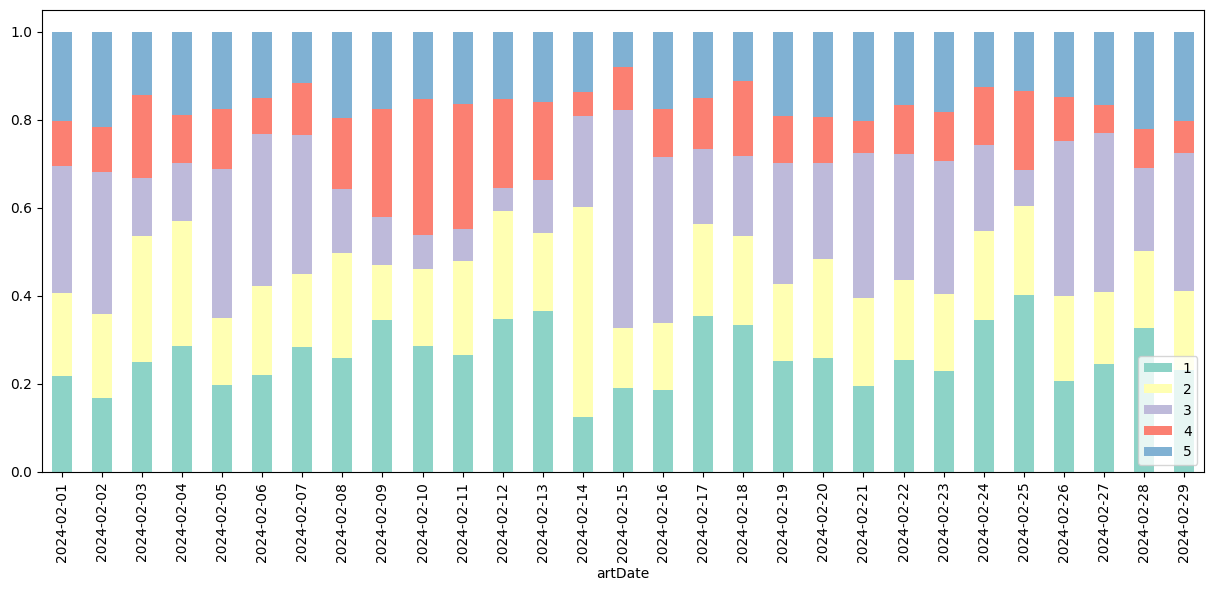

In [157]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。